# Introduction

This notebook will serve to present the results obtained with the Super Resolution model.

We will show validation results of the best model found during model selection and test results.

The training was performed on an Nvidia laptop GPU with the following specifications:

The command 
```bash
nvaccelinfo
```
gives the following output
```
CUDA Driver Version:           12050
NVRM version:                  NVIDIA UNIX x86_64 Kernel Module  555.58.02  Tue Jun 25 01:39:15 UTC 2024

Device Number:                 0
Device Name:                   NVIDIA GeForce RTX 3050 Ti Laptop GPU
Device Revision Number:        8.6
Global Memory Size:            3993436160
Number of Multiprocessors:     20
Concurrent Copy and Execution: Yes
Total Constant Memory:         65536
Total Shared Memory per Block: 49152
Registers per Block:           65536
Warp Size:                     32
Maximum Threads per Block:     1024
Maximum Block Dimensions:      1024, 1024, 64
Maximum Grid Dimensions:       2147483647 x 65535 x 65535
Maximum Memory Pitch:          2147483647B
Texture Alignment:             512B
Clock Rate:                    1485 MHz
Execution Timeout:             Yes
Integrated Device:             No
Can Map Host Memory:           Yes
Compute Mode:                  default
Concurrent Kernels:            Yes
ECC Enabled:                   No
Memory Clock Rate:             6001 MHz
Memory Bus Width:              128 bits
L2 Cache Size:                 2097152 bytes
Max Threads Per SMP:           1536
Async Engines:                 2
Unified Addressing:            Yes
Managed Memory:                Yes
Concurrent Managed Memory:     Yes
Preemption Supported:          Yes
Cooperative Launch:            Yes
Default Target:                cc86
```

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset.data_preparation import download, split_dataset
from dataset.super_resolution_dataset import SuperResolutionDataset
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
import numpy as np
from SRM.network import SuperResolution
from torchmetrics.functional.image import peak_signal_noise_ratio
sns.set_style("darkgrid")
sns.set_context("talk")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.cuda.is_available()

False

# Download the dataset

Set a seed for reproducibility. This seed is the same used in the main method to achieve the same results

In [3]:
torch.manual_seed(777)

download("./data", "airplanes")
root_dir = 'data/airplanes'
dataset = SuperResolutionDataset(root_dir=root_dir)
dataset_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Dataset airplanes already exists, skipping download.


## Exploring the dataset

The dataset is composed by couples of low and high resolution images.
The images are 128x64 and 256x128 respectively.
For simplicity, we have cropped all the images to have the same dimension.

> The dataset is made just of airplanes images

Below there is a plot with a low resolution image with the corresponding high resolution image.

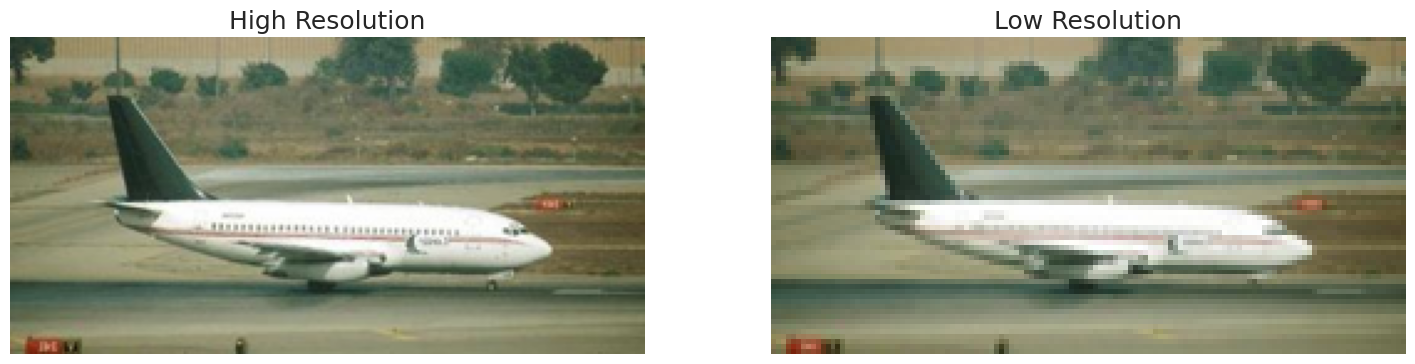

In [4]:
low_res, high_res = next(iter(dataset_dataloader))
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].imshow(high_res[0].permute(1, 2, 0))
ax[0].set_title("High Resolution")
ax[0].axis('off')

ax[1].imshow(low_res[0].permute(1, 2, 0))
ax[1].set_title("Low Resolution")
ax[1].axis('off')

plt.show()

# Data Splitting

We will use the same split size used during training.

In [5]:
sizes = {
    "train":0.5,
    "validation":0.3,
    "test":0.2
}
_ , validation, test = split_dataset(dataset,sizes)

validation_dataloader = DataLoader(test, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=True)

# Learning

The model has been trained for 50 epochs for validation purpose, after that it was trained for another 150 epochs with training and validation dataset merged together.

## Learning Curve of L1 loss

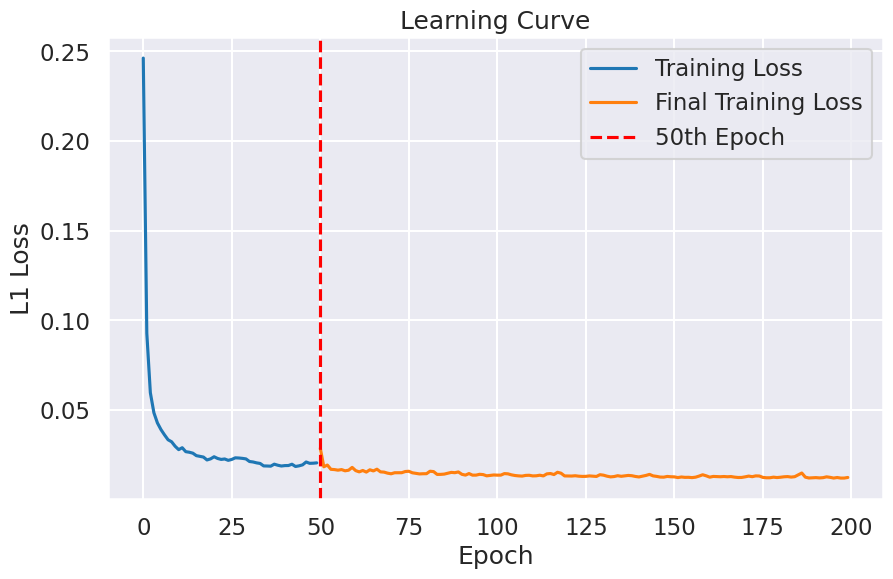

In [13]:
training_loss = "training_logs/202408051714_L1.csv"
final_training_loss = "training_logs/202408051740_L1.csv"
training_loss = genfromtxt(training_loss, delimiter=',')
final_training_loss = genfromtxt(final_training_loss, delimiter=',')

plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(len(training_loss)), y=training_loss, label='Training Loss')
sns.lineplot(x=np.arange(len(training_loss), len(training_loss) + len(final_training_loss)), 
             y=final_training_loss, label='Final Training Loss')

plt.axvline(x=50, color='red', linestyle='--', label='50th Epoch')
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## PSNR in decibel

The peak signal-to-noise ratio is a measurement for image quality with the following convention:

-  PSNR < 20 Low quality
-  20 < PSNR < 30 Medium quality
- PSNR > High quality

Quality is respect to the original image, it does not mean that the image is in high resolution.

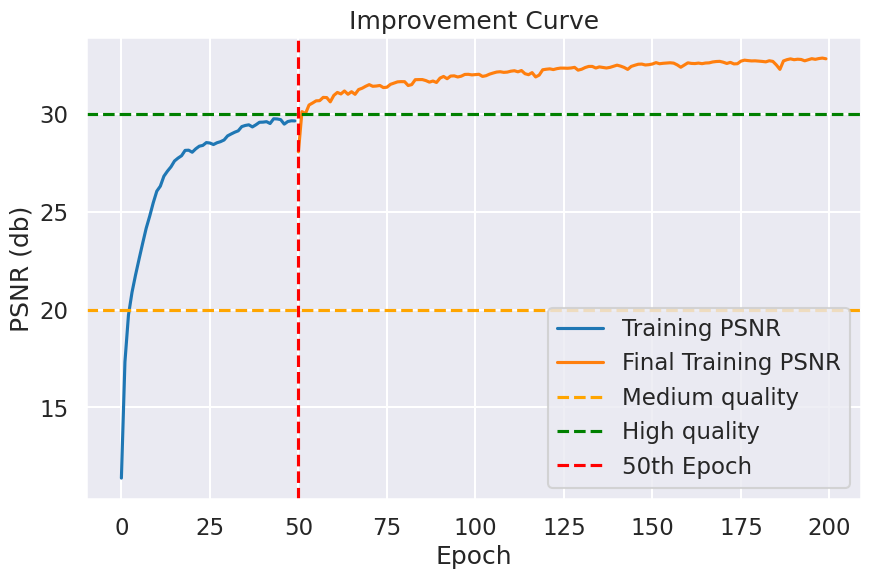

In [14]:
training_psnr = "training_logs/202408051714_psnr.csv"
final_training_psnr = "training_logs/202408051740_psnr.csv"
training_psnr = genfromtxt(training_psnr, delimiter=',')
final_training_psnr = genfromtxt(final_training_psnr, delimiter=',')

plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(len(training_psnr)), y=training_psnr, label='Training PSNR')
sns.lineplot(x=np.arange(len(training_psnr), len(training_psnr) + len(final_training_psnr)), 
             y=final_training_psnr, label='Final Training PSNR')

plt.axhline(y=20, color='orange', linestyle='--', label='Medium quality')
plt.axhline(y=30, color='green', linestyle='--', label='High quality')

plt.axvline(x=50, color='red', linestyle='--', label='50th Epoch')
plt.xlabel('Epoch')
plt.ylabel('PSNR (db)')
plt.title('Improvement Curve')
plt.legend()
plt.show()

We can see that after starting to retrain the model with also the validation dataset, increase the quality of the **up scaling**.

# Validation and visual comparison

We can load the trained model with 50 epochs (used for validation) to get the Loss and PSNR values.


In [6]:
from utils.training_utilitis import validate
model_filename = "checkpoint/SR_c64_rb8_e50_202408051714.pth"
validation_SRN = SuperResolution(64,8)
checkpoint_path = model_filename
validation_SRN.load_state_dict(
    torch.load(checkpoint_path,map_location=device)
)

loss, psnr = validate(validation_SRN,validation_dataloader,
                      {"loss_fn":nn.L1Loss(),"device":device})
print(f"Validation L1: {loss:.6f}, PSNR {psnr:.4f} db")

low_res_validation, high_res_validation = next(iter(validation_dataloader))

low_res_validation = low_res_validation.to(device)
high_res_validation = high_res_validation.to(device)

with torch.no_grad():
    predicted_high_res = validation_SRN(low_res_validation)
    
validation_psnr = peak_signal_noise_ratio(predicted_high_res, high_res_validation)

bilinear = nn.Upsample(scale_factor=2,mode="bilinear")
bilinear_image = bilinear(low_res_validation)
bilinear_psnr = peak_signal_noise_ratio(bilinear_image, high_res_validation)
predicted_image = torch.clamp(predicted_high_res[0], 0, 1).permute(1, 2, 0).cpu().numpy()
_, ax = plt.subplots(2, 2, figsize=(18, 12)) 

ax[0,0].imshow(high_res_validation[0].permute(1, 2, 0).cpu())
ax[0,0].set_title("Real High Resolution")
ax[0,0].axis('off') 

ax[0,1].imshow(low_res_validation[0].permute(1, 2, 0).cpu())
ax[0,1].set_title(f"Low resolution")
ax[0,1].axis('off')

ax[1,0].imshow(predicted_image)
ax[1,0].set_title(f"Predicted High Resolution {validation_psnr:.4f} db")
ax[1,0].axis('off')

ax[1,1].imshow(bilinear_image[0].permute(1, 2, 0).cpu())
ax[1,1].set_title(f"Bilinear High Resolution {bilinear_psnr:.4f} db")
ax[1,1].axis('off')

os.makedirs("output", exist_ok=True) 
plt.savefig("output/validation_prediction_comparison.jpg")
plt.show()

RuntimeError: Error(s) in loading state_dict for SuperResolution:
	Missing key(s) in state_dict: "layers.0.kernel", "layers.1.conv1.kernel", "layers.1.conv2.kernel", "layers.2.conv1.kernel", "layers.2.conv2.kernel", "layers.3.conv1.kernel", "layers.3.conv2.kernel", "layers.4.conv1.kernel", "layers.4.conv2.kernel", "layers.5.conv1.kernel", "layers.5.conv2.kernel", "layers.6.conv1.kernel", "layers.6.conv2.kernel", "layers.7.conv1.kernel", "layers.7.conv2.kernel", "layers.8.conv1.kernel", "layers.8.conv2.kernel", "layers.9.conv.kernel", "layers.10.kernel". 
	Unexpected key(s) in state_dict: "layers.0.weight", "layers.0.bias", "layers.1.conv1.weight", "layers.1.conv1.bias", "layers.1.conv2.weight", "layers.1.conv2.bias", "layers.2.conv1.weight", "layers.2.conv1.bias", "layers.2.conv2.weight", "layers.2.conv2.bias", "layers.3.conv1.weight", "layers.3.conv1.bias", "layers.3.conv2.weight", "layers.3.conv2.bias", "layers.4.conv1.weight", "layers.4.conv1.bias", "layers.4.conv2.weight", "layers.4.conv2.bias", "layers.5.conv1.weight", "layers.5.conv1.bias", "layers.5.conv2.weight", "layers.5.conv2.bias", "layers.6.conv1.weight", "layers.6.conv1.bias", "layers.6.conv2.weight", "layers.6.conv2.bias", "layers.7.conv1.weight", "layers.7.conv1.bias", "layers.7.conv2.weight", "layers.7.conv2.bias", "layers.8.conv1.weight", "layers.8.conv1.bias", "layers.8.conv2.weight", "layers.8.conv2.bias", "layers.9.conv.weight", "layers.9.conv.bias", "layers.10.weight", "layers.10.bias". 

When comparing this Super Resolution model to other techniques, such as bilinear up scaling,
we observe that our model achieves a slightly higher PSNR score, indicating a higher quality output. Additionally, 
the images produced by our model appear significantly less blurry.

# Test and visual comparison

We can load the final model to test it and get Loss and PSNR values.

Test L1: 0.012140, PSNR 32.9143 db


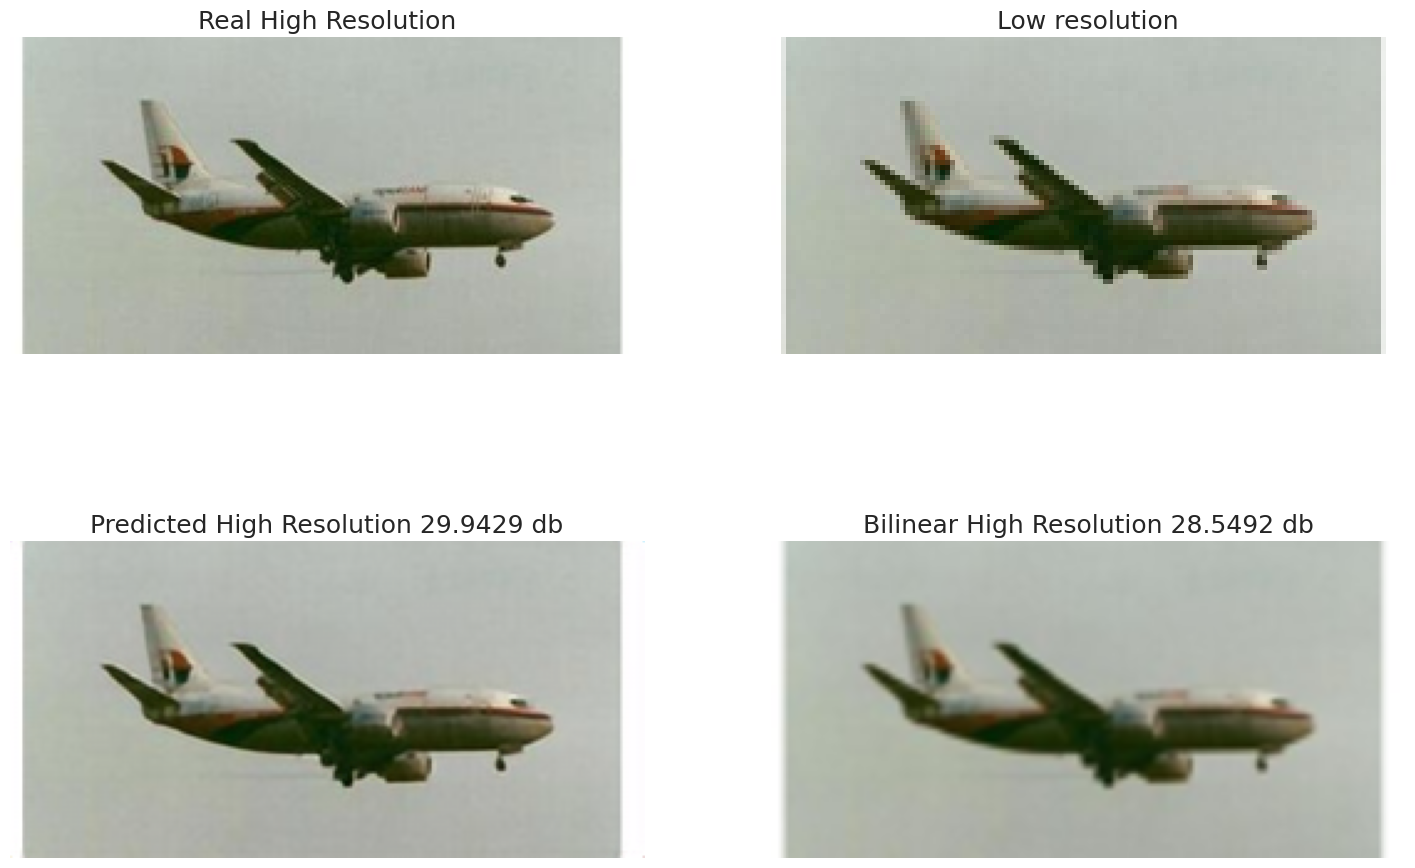

In [16]:
model_filename = "checkpoint/SR_c64_rb8_e150_202408051740.pth"
test_SRN = SuperResolution(64,8)
checkpoint_path = model_filename
test_SRN.load_state_dict(
    torch.load(checkpoint_path,map_location=device)
)

loss, psnr = test_SRN.test(nn.L1Loss(), test_dataloader ,device)
print(f"Test L1: {loss:.6f}, PSNR {psnr:.4f} db")

low_res_test, high_res_test = next(iter(test_dataloader))

low_res_test = low_res_test.to(device)
high_res_test = high_res_test.to(device)

with torch.no_grad():
    predicted_high_res = test_SRN(low_res_test)
    
bilinear = nn.Upsample(scale_factor=2,mode="bilinear")
bilinear_image = bilinear(low_res_test)
bilinear_psnr = peak_signal_noise_ratio(bilinear_image, high_res_test)
predicted_image = torch.clamp(predicted_high_res[0], 0, 1).permute(1, 2, 0).cpu().numpy()
_, ax = plt.subplots(2, 2, figsize=(18, 12)) 

ax[0,0].imshow(high_res_test[0].permute(1, 2, 0).cpu())
ax[0,0].set_title("Real High Resolution")
ax[0,0].axis('off') 

ax[0,1].imshow(low_res_test[0].permute(1, 2, 0).cpu())
ax[0,1].set_title(f"Low resolution")
ax[0,1].axis('off')

ax[1,0].imshow(predicted_image)
ax[1,0].set_title(f"Predicted High Resolution {validation_psnr:.4f} db")
ax[1,0].axis('off')

ax[1,1].imshow(bilinear_image[0].permute(1, 2, 0).cpu())
ax[1,1].set_title(f"Bilinear High Resolution {bilinear_psnr:.4f} db")
ax[1,1].axis('off')

os.makedirs("output", exist_ok=True) 
plt.savefig("output/test_prediction_comparison.jpg")
plt.show()

The lower loss observed in the test set compared to the validation set can be attributed to the additional 150 epochs of training 
applied to the model.

Given the initial low quality of the images, the model performs satisfactorily. It outperforms a basic algorithm designed to double
the resolution of airplane images. The small size of the input images is also reflected in the model's architecture, which is half 
the depth of the model described in the referenced paper. The model was carefully selected from various combinations of potential 
parameters.